In [162]:
from qiskit_ibm_provider import IBMProvider, least_busy
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, ZFeatureMap, EfficientSU2
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.algorithms.optimizers import COBYLA, SLSQP
from qiskit_ibm_runtime import Sampler, QiskitRuntimeService, Options
import sklearn.model_selection
#import sklearn.datasets
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import pandas as pd
import numpy as np
from IPython.display import clear_output
from matplotlib import pyplot as plt
import seaborn as sb
import os.path
import time

Code is based on [the tutorial found here](https://qiskit.org/documentation/machine-learning/tutorials/02_neural_network_classifier_and_regressor.html#Regression).
**Data preparation**

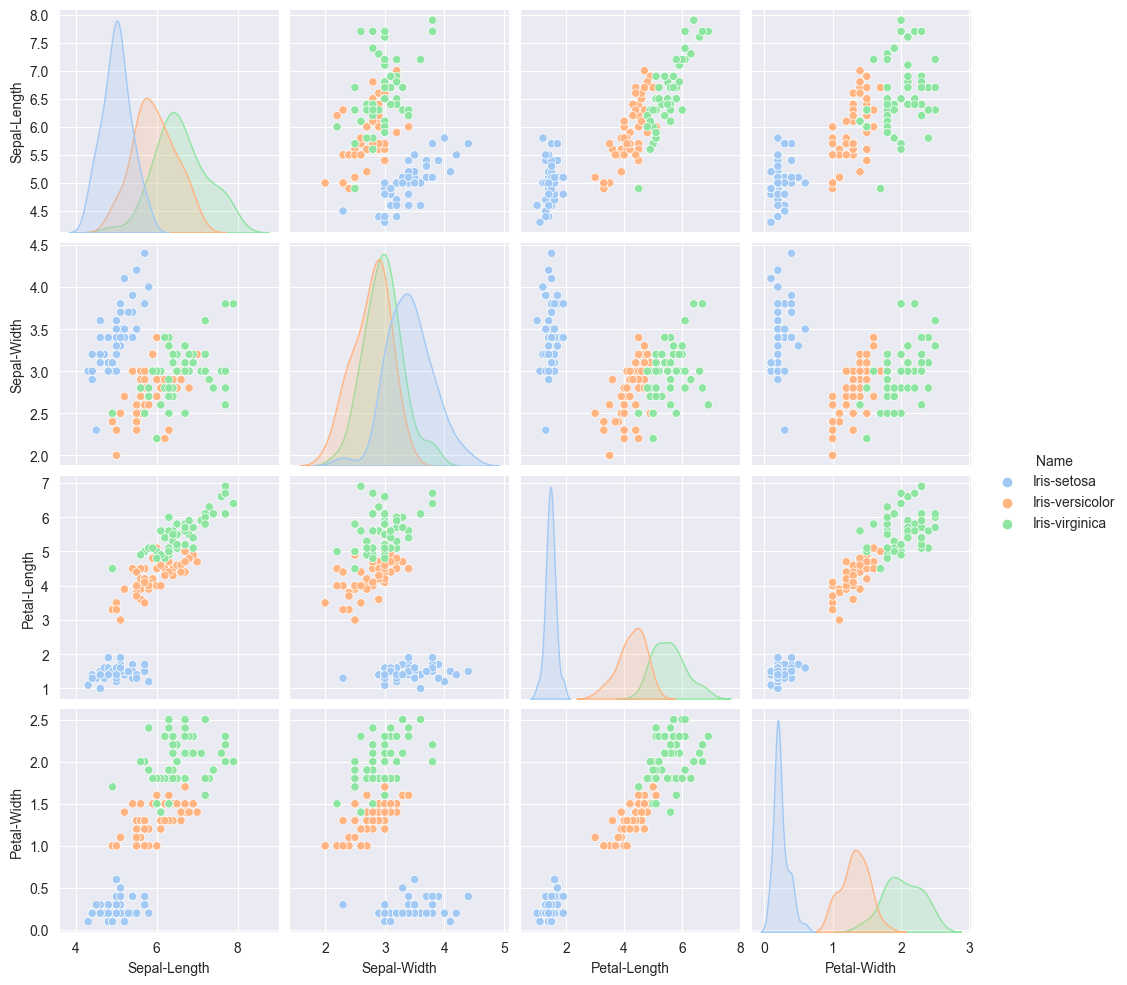

In [163]:
data_path = os.path.normpath("./data/iris.data")
iris = pd.read_csv(data_path, names=["Sepal-Length", "Sepal-Width", "Petal-Length", "Petal-Width", "Name"])
sb.pairplot(iris, hue="Name", palette="pastel")

Separate the features and the labels (which is our target). We also preprocess the features and labels (normalizing and categorizing respectively)

In [164]:
iris_features = iris.loc[:, ["Sepal-Length", "Sepal-Width", "Petal-Length", "Petal-Width"]].values
iris_labels = iris.loc[:, "Name"].values
iris_features = StandardScaler().fit_transform(iris_features)
iris_labels = OrdinalEncoder().fit_transform(iris_labels.reshape(-1,1))
display(iris_features.shape)
iris_labels = iris_labels[:,0]
display(iris_labels.shape)

(150, 4)

(150,)

We separate the now preprocessed data into a training set and a test set with a 80:20 split.

In [165]:
train_features, test_features, train_labels, test_labels = sklearn.model_selection.train_test_split(
    iris_features,
    iris_labels,
    train_size=0.8,
)
display(train_features.shape, train_labels.shape, test_features.shape, test_labels.shape)

(120, 4)

(120,)

(30, 4)

(30,)

**Creating the QNN**
We now will make the QNN to process our data.

In [166]:
num_features = iris_features.shape[1]
circuit = QuantumCircuit(num_features)
feature_map = ZFeatureMap(num_features, reps=2)
ansatz = EfficientSU2(num_features, reps=2)
circuit.compose(feature_map, inplace=True)
circuit.compose(ansatz, inplace=True)
circuit.draw()

┌───────────────────────────────────┐»
q_0: ┤0                                  ├»
     │                                   │»
q_1: ┤1                                  ├»
     │  ZFeatureMap(x[0],x[1],x[2],x[3]) │»
q_2: ┤2                                  ├»
     │                                   │»
q_3: ┤3                                  ├»
     └───────────────────────────────────┘»
«     ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                                                                     ├
«     │                                                                                                                                                      │
«q_1: ┤1                                                                                                                                                     ├
«     │  EfficientSU2(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7],θ[8],θ[9],θ[10],θ[11],θ[12],θ[13],θ[14],θ[15],θ[16],θ[17],θ[18],θ[19],θ[20],θ[21],θ[22],θ[23]) │
«q_2: ┤2                                                                                                                                                     ├
«     │                                                                                                                                                      │
«q_3: ┤3                                                                                                                                                     ├
«     └──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [167]:
def interpret(x):
    return x%3

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q-asu/main/pi-deluca',
)

options = Options()
options.execution.shots = 512
options.optimization_level = 3
options.resilience_level = 1
backend = service.least_busy(min_num_qubits=3, filters=lambda b: b.configuration().simulator == True)
custom_sampler = Sampler(session=backend, options=options)
sampler = SamplerQNN(sampler=custom_sampler,
                     circuit=circuit,
                     input_params=feature_map.parameters,
                     weight_params=ansatz.parameters,
                     interpret=interpret,
                     output_shape=3)
print(backend.name)

ibmq_qasm_simulator


In [168]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
plt.clf()
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

<Figure size 1200x600 with 0 Axes>

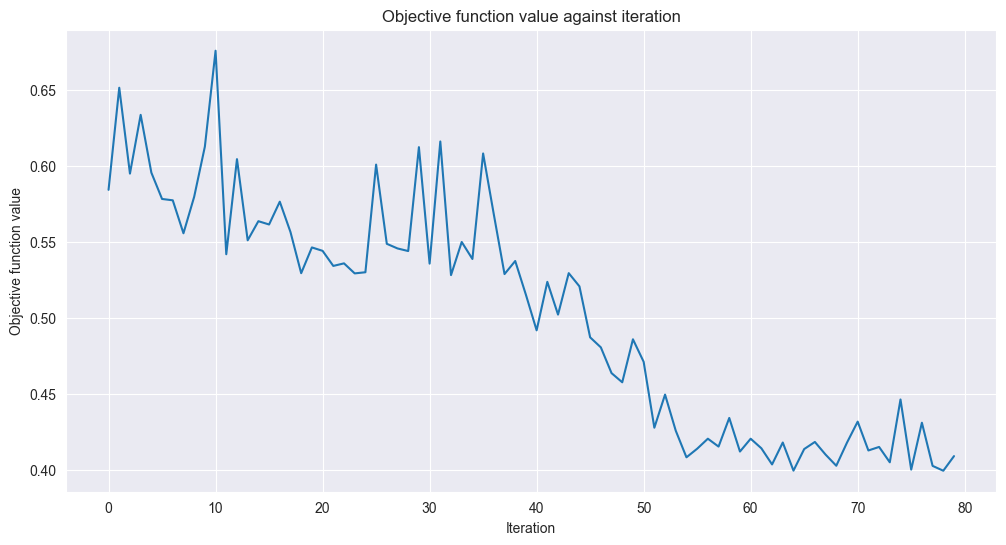

Model trained in 1257.4831 seconds


In [169]:
classifier = NeuralNetworkClassifier(sampler, one_hot=True, optimizer=COBYLA(maxiter=80), callback=callback_graph)
plt.clf()
start = time.time()
classifier.fit(train_features, train_labels)
finish = time.time() - start
print(f"Model trained in {finish:.4f} seconds")

In [170]:
training_score = classifier.score(train_features, train_labels)
print(f"Training dataset score: {training_score:.2f}")
testing_score = classifier.score(test_features, test_labels)
print(f"Test dataset score:     {testing_score:.2f}")

Training dataset score: 0.81
Test dataset score:     0.80
